# 비지도학습 군집화 테스트

###  "사용 데이터 : 장르별 베스트셀러 리뷰 모음"
### 최적 토픽 갯수 테스트

### 조건
    * 각각의 ISBN끼리 리뷰를 합쳐서 테스트
    * 명사

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

%matplotlib inline

import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib

In [2]:
import konlpy
from konlpy.tag import Okt

In [4]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# 데이터 전처리

## 도서 리뷰 추가

In [5]:
import glob
import pandas as pd
from pandas.core.dtypes.missing import notnull
import nltk
from konlpy.tag import Okt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import re
from gensim.models import Word2Vec
from pandas import DataFrame
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## <전처리>

In [6]:
def cleansing(text):
    # text = str(text)
    pattern = "([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+.[a-zA-Z0-9-.]+)"  # e-mail 주소 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "(http|ftp|https)://(?:[-\w.]|(?:\da-fA-F]{2}))+"  # url 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "([^ㄷㅋㅎㅜㅠ가-힣a-zA-Z0-9])+"  # 한글 자음, 모음 제거 - without 'ㄷ,ㅋ,ㅎ,ㅜ,ㅠ'
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "<[^>]*>"  # html tag 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "[\r|\n]"  # \r, \n 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = re.compile(r"\s+")  # 이중 space 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    return text

### ISBN을 기준으로 리뷰를 모은 뒤 재조합

## <토큰화>

#### 분류 테스트 

In [7]:
okt = Okt()

----

### 기존 데이터 가져오기

In [8]:
# 불러오기
import pickle

book_morphs_with_isbn_pos_non_stopword = []
with open('data/detail_bestbook_unit_isbn_with_isbn_pos_non_stopword.txt', 'rb') as lf:
    book_morphs_with_isbn_pos_non_stopword = pickle.load(lf)
    
print(book_morphs_with_isbn_pos_non_stopword[0])

[9788959752195, [('내', 'Noun'), ('가제', 'Noun'), ('일', 'Noun'), ('좋아하다', 'Adjective'), ('책', 'Noun'), ('이', 'Noun'), ('당', 'Noun'), ('6', 'Number')]]


In [10]:
print(len(book_morphs_with_isbn_pos_non_stopword))
print(book_morphs_with_isbn_pos_non_stopword[2])

42559
[9791127420949, [('덕분', 'Noun'), ('에', 'Josa'), ('귀엽다', 'Adjective'), ('SD', 'Alpha'), ('를', 'Noun'), ('그릴', 'Noun'), ('수', 'Noun'), ('있다', 'Adjective'), ('되어다', 'Verb'), ('너무', 'Adverb'), ('기쁘다', 'Adjective'), ('별', 'Noun'), ('5', 'Number'), ('개', 'Noun'), ('로', 'Noun'), ('도', 'Noun'), ('사실', 'Noun'), ('모자라다', 'Verb'), ('정도', 'Noun'), ('로', 'Noun'), ('좋다', 'Adjective'), ('책', 'Noun'), ('채색', 'Noun'), ('이', 'Noun'), ('없다', 'Adjective'), ('게', 'Noun'), ('좀', 'Noun'), ('아쉽다', 'Adjective'), ('채색', 'Noun'), ('책', 'Noun'), ('이', 'Noun'), ('아니다', 'Adjective'), ('별', 'Noun'), ('기대', 'Noun'), ('안', 'Noun'), ('하다', 'Verb'), ('생각', 'Noun'), ('보다', 'Verb'), ('내용', 'Noun'), ('이', 'Noun'), ('알차다', 'Adjective'), ('두고두고', 'Noun'), ('볼', 'Noun'), ('것', 'Noun'), ('같다', 'Adjective')]]


In [11]:
#  도서 불용어를 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','것','라고','에게','라면','을','이라',
             '라니','있다','아','랑','쯤된','에서','에선','어','이지만','으로나','때','때는','때라면','때라서','라','이다','있','죠','고','니','로','있','같',
             '어서','어요','는데','습니다','면서','많이','마','더','그렇다','의','당','좀','책','안','볼','게','안','정말','듯','이제야','여','요','게다가','같다',
            '임','로서','이제','만','인','붙이','그','저','수','가제','부터','닷','저희','적','알','쉬','못','꼭','살','제','권','제','분','나','내', '진작', '전', '뿐'
            , '대한','대해','책','좋다']

In [12]:
######### 태깅한 데이터 중에서 명사 +불용어 처리

book_train_nouns = []
book_train_isbn = []
for (isbn, test) in book_morphs_with_isbn_pos_non_stopword :
    tts = [(word,pos) for (word,pos) in test if not word in stopwords] #불용어 처리
    na = [word for (word,pos) in tts if pos in 'Noun'] # 명사만 저장

    if na : 
        book_train_nouns.append(na)
        book_train_isbn.append(isbn)

print('**********************END***************************')
print(len(book_train_nouns))
print(len(book_train_isbn))

**********************END***************************
42337
42337


In [13]:
for i in range(0,5) :
#     print(book_morphs_with_isbn_pos_non_stopword[i])
    print(book_train_nouns[i])

['일']
['처음', '제목', '보고', '예상', '스토리', '완전', '신간', '홀린', '장바구니', '사서', '맘', '사서', '걸', '조금', '여자', '이야기']
['덕분', '그릴', '별', '개', '사실', '정도', '채색', '채색', '별', '기대', '생각', '내용', '두고두고']
['구매', '쭉', '지리', '여행', '여행', '가기']
['요가', '궁극', '의미', '요가', '수행자', '위', '메시지', '방법', '과정', '자세', '설명', '알다', '정리', '매우', '서적', '요가', '공부', '위해', '구입', '공부', '도움', '요가', '교과서', '말', '요가', '백과사전', '식', '명작', '설명', '그림', '첨부', '재미', '실제', '응용', '위', '참고서', '아헹', '선생님', '요가', '알라딘', '쿠폰', '무료', '배송', '보아', '요가', '교과서', '최고', '요가', '입문', '무리']


----

## 최적 토픽의 수 테스트

In [15]:
from tqdm import tqdm 
import re 
from gensim.models.ldamodel import LdaModel 
from gensim.models.callbacks import CoherenceMetric 
from gensim import corpora 
from gensim.models.callbacks import PerplexityMetric 
import logging 
import pickle 
import pyLDAvis.gensim 
from gensim.models.coherencemodel import CoherenceModel 
import matplotlib.pyplot as plt 


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3): 
    coherence_values = [] 
    model_list = [] 
    for num_topics in range(start, limit, step): 
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics) 
        model_list.append(model) 
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v') 
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values 
    
def find_optimal_number_of_topics(dictionary, corpus, processed_data): 
    limit = 40;
    start = 2; 
    step = 6; 

    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step) 
    
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence_values"), loc='best')
    plt.show() 

d:\project02\field-team4_test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-03-26 15:36:39,524 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-03-26 15:36:40,253 : INFO : adding document #10000 to Dictionary(28700 unique tokens: ['일', '걸', '맘', '보고', '사서']...)
2021-03-26 15:36:40,951 : INFO : adding document #20000 to Dictionary(38684 unique tokens: ['일', '걸', '맘', '보고', '사서']...)
2021-03-26 15:36:41,615 : INFO : adding document #30000 to Dictionary(45161 unique tokens: ['일', '걸', '맘', '보고', '사서']...)
2021-03-26 15:36:42,363 : INFO : adding document #40000 to Dictionary(51442 unique tokens: ['일', '걸', '맘', '보고', '사서']...)
2021-03-26 15:36:42,546

Number of unique tokens: 11814
Number of documents: 42337


2021-03-26 15:36:45,055 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:36:45,059 : INFO : topic #0 (0.500): 0.005*"아빠" + 0.004*"여행" + 0.004*"엄마" + 0.003*"경주" + 0.003*"김진명" + 0.003*"영어" + 0.003*"스토리" + 0.002*"마지막" + 0.002*"자기" + 0.002*"주인공"
2021-03-26 15:36:45,060 : INFO : topic #1 (0.500): 0.004*"엄마" + 0.003*"도서관" + 0.003*"만화" + 0.003*"여성" + 0.003*"시집" + 0.002*"시인" + 0.002*"감정" + 0.002*"관" + 0.002*"일본" + 0.002*"영화"
2021-03-26 15:36:45,060 : INFO : topic diff=2.458910, rho=1.000000
2021-03-26 15:36:45,061 : INFO : PROGRESS: pass 0, at document #4000/42337
2021-03-26 15:36:46,077 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:36:46,079 : INFO : topic #0 (0.500): 0.004*"문구" + 0.003*"영어" + 0.003*"엄마" + 0.003*"딸" + 0.003*"문" + 0.003*"좀비" + 0.003*"여행" + 0.003*"아들" + 0.003*"문법" + 0.003*"면접"
2021-03-26 15:36:46,080 : INFO : topic #1 (0.500): 0.003*"엄마" + 0.003*"영화" + 0.003*"좀비" + 0.003*"감정" + 0.003*"사진" + 0

2021-03-26 15:36:55,431 : INFO : topic #1 (0.500): 0.004*"영화" + 0.004*"만화" + 0.003*"사진" + 0.003*"고양이" + 0.003*"소장" + 0.003*"매력" + 0.003*"주인공" + 0.002*"순간" + 0.002*"여성" + 0.002*"스토리"
2021-03-26 15:36:55,431 : INFO : topic diff=0.255364, rho=0.267261
2021-03-26 15:36:55,431 : INFO : PROGRESS: pass 0, at document #30000/42337
2021-03-26 15:36:55,992 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:36:55,994 : INFO : topic #0 (0.500): 0.007*"영어" + 0.007*"교재" + 0.006*"개념" + 0.006*"연산" + 0.005*"단어" + 0.005*"기본" + 0.004*"수학" + 0.004*"학습" + 0.004*"엄마" + 0.004*"준비"
2021-03-26 15:36:55,995 : INFO : topic #1 (0.500): 0.004*"만화" + 0.004*"영화" + 0.003*"사진" + 0.003*"고양이" + 0.003*"소장" + 0.003*"여성" + 0.003*"매력" + 0.002*"주인공" + 0.002*"마지막" + 0.002*"감정"
2021-03-26 15:36:55,996 : INFO : topic diff=0.235007, rho=0.258199
2021-03-26 15:36:55,997 : INFO : PROGRESS: pass 0, at document #32000/42337
2021-03-26 15:36:56,547 : INFO : merging changes from 2000 documents i

2021-03-26 15:37:07,925 : INFO : 64 batches submitted to accumulate stats from 4096 documents (5938 virtual)
2021-03-26 15:37:07,968 : INFO : 66 batches submitted to accumulate stats from 4224 documents (5224 virtual)
2021-03-26 15:37:08,012 : INFO : 72 batches submitted to accumulate stats from 4608 documents (-6230 virtual)
2021-03-26 15:37:08,016 : INFO : 73 batches submitted to accumulate stats from 4672 documents (-5886 virtual)
2021-03-26 15:37:08,035 : INFO : 76 batches submitted to accumulate stats from 4864 documents (-6562 virtual)
2021-03-26 15:37:08,041 : INFO : 77 batches submitted to accumulate stats from 4928 documents (-1138 virtual)
2021-03-26 15:37:08,046 : INFO : 78 batches submitted to accumulate stats from 4992 documents (-159 virtual)
2021-03-26 15:37:08,078 : INFO : 81 batches submitted to accumulate stats from 5184 documents (1136 virtual)
2021-03-26 15:37:08,090 : INFO : 82 batches submitted to accumulate stats from 5248 documents (2507 virtual)
2021-03-26 15:3

2021-03-26 15:37:09,697 : INFO : 308 batches submitted to accumulate stats from 19712 documents (-136111 virtual)
2021-03-26 15:37:09,701 : INFO : 309 batches submitted to accumulate stats from 19776 documents (-135284 virtual)
2021-03-26 15:37:09,706 : INFO : 310 batches submitted to accumulate stats from 19840 documents (-133164 virtual)
2021-03-26 15:37:09,712 : INFO : 311 batches submitted to accumulate stats from 19904 documents (-125974 virtual)
2021-03-26 15:37:09,721 : INFO : 312 batches submitted to accumulate stats from 19968 documents (-125567 virtual)
2021-03-26 15:37:09,725 : INFO : 313 batches submitted to accumulate stats from 20032 documents (-124166 virtual)
2021-03-26 15:37:09,730 : INFO : 314 batches submitted to accumulate stats from 20096 documents (-123916 virtual)
2021-03-26 15:37:09,743 : INFO : 315 batches submitted to accumulate stats from 20160 documents (-121872 virtual)
2021-03-26 15:37:09,756 : INFO : 316 batches submitted to accumulate stats from 20224 do

2021-03-26 15:37:14,111 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:37:14,116 : INFO : topic #0 (0.125): 0.008*"일본" + 0.007*"투자" + 0.006*"엄마" + 0.006*"주식" + 0.006*"시집" + 0.005*"부모" + 0.005*"시인" + 0.005*"글쓰기" + 0.004*"윤동주" + 0.004*"독서"
2021-03-26 15:37:14,117 : INFO : topic #4 (0.125): 0.007*"나무" + 0.006*"어른" + 0.005*"고양이" + 0.005*"사진" + 0.005*"손" + 0.004*"아들" + 0.004*"발효" + 0.004*"집중" + 0.004*"그림책" + 0.003*"상상력"
2021-03-26 15:37:14,118 : INFO : topic #5 (0.125): 0.008*"여행" + 0.007*"영화" + 0.006*"감정" + 0.004*"가슴" + 0.003*"독서" + 0.003*"마지막" + 0.003*"인물" + 0.003*"주인공" + 0.003*"순간" + 0.003*"곳"
2021-03-26 15:37:14,119 : INFO : topic #1 (0.125): 0.008*"영어" + 0.007*"레시피" + 0.006*"요리" + 0.005*"소장" + 0.005*"영문법" + 0.005*"완전" + 0.005*"드라마" + 0.004*"도깨비" + 0.004*"영화" + 0.004*"좀비"
2021-03-26 15:37:14,119 : INFO : topic #7 (0.125): 0.009*"하루키" + 0.007*"학년" + 0.007*"여행" + 0.005*"파스타" + 0.005*"영어" + 0.004*"교과서" + 0.003*"패턴" + 0.003*"초등" + 0.003*"도서" + 0.0

2021-03-26 15:37:19,742 : INFO : topic #6 (0.125): 0.010*"과학" + 0.009*"철학" + 0.005*"문화" + 0.005*"교수" + 0.005*"지식" + 0.005*"경제" + 0.005*"중국" + 0.004*"시각" + 0.004*"정치" + 0.004*"현재"
2021-03-26 15:37:19,743 : INFO : topic #7 (0.125): 0.012*"여행" + 0.008*"다이어트" + 0.007*"영어" + 0.007*"한국사" + 0.006*"학년" + 0.006*"선생님" + 0.005*"가시" + 0.005*"게이고" + 0.004*"공기업" + 0.004*"도서"
2021-03-26 15:37:19,744 : INFO : topic #2 (0.125): 0.017*"수학" + 0.017*"학습" + 0.014*"단어" + 0.011*"하루" + 0.011*"한자" + 0.010*"개념" + 0.009*"영어" + 0.009*"매일" + 0.009*"교재" + 0.008*"어휘"
2021-03-26 15:37:19,745 : INFO : topic #5 (0.125): 0.009*"영화" + 0.006*"순간" + 0.004*"감정" + 0.004*"가슴" + 0.004*"마지막" + 0.003*"여성" + 0.003*"주인공" + 0.003*"위로" + 0.003*"그녀" + 0.003*"인물"
2021-03-26 15:37:19,746 : INFO : topic #1 (0.125): 0.010*"요리" + 0.009*"만화" + 0.008*"소장" + 0.008*"레시피" + 0.007*"스토리" + 0.007*"드라마" + 0.006*"웹툰" + 0.005*"완전" + 0.005*"주문" + 0.005*"영화"
2021-03-26 15:37:19,747 : INFO : topic diff=0.324428, rho=0.301511
2021-03-26 15:37:19,748 : I

2021-03-26 15:37:23,763 : INFO : topic #7 (0.125): 0.029*"여행" + 0.009*"선생님" + 0.006*"하루키" + 0.006*"한국사" + 0.006*"학년" + 0.006*"사진" + 0.005*"영어" + 0.005*"곳" + 0.004*"패턴" + 0.004*"정보"
2021-03-26 15:37:23,764 : INFO : topic #6 (0.125): 0.015*"과학" + 0.012*"철학" + 0.010*"경제학" + 0.008*"경제" + 0.007*"중국" + 0.007*"지식" + 0.006*"미래" + 0.006*"교수" + 0.005*"주의" + 0.005*"관점"
2021-03-26 15:37:23,765 : INFO : topic #2 (0.125): 0.024*"수학" + 0.021*"연산" + 0.020*"개념" + 0.018*"학습" + 0.015*"단어" + 0.013*"영어" + 0.013*"교재" + 0.011*"학년" + 0.011*"하루" + 0.010*"문"
2021-03-26 15:37:23,766 : INFO : topic #3 (0.125): 0.016*"영어" + 0.014*"교재" + 0.013*"강의" + 0.010*"기본" + 0.010*"기초" + 0.009*"시험" + 0.009*"준비" + 0.008*"입문" + 0.007*"유형" + 0.007*"일본어"
2021-03-26 15:37:23,767 : INFO : topic diff=0.214400, rho=0.235702
2021-03-26 15:37:23,767 : INFO : PROGRESS: pass 0, at document #38000/42337
2021-03-26 15:37:24,310 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:37:24,316 : INFO : topi

2021-03-26 15:37:34,164 : INFO : 144 batches submitted to accumulate stats from 9216 documents (-231199 virtual)
2021-03-26 15:37:34,170 : INFO : 145 batches submitted to accumulate stats from 9280 documents (-231063 virtual)
2021-03-26 15:37:34,219 : INFO : 148 batches submitted to accumulate stats from 9472 documents (-233418 virtual)
2021-03-26 15:37:34,266 : INFO : 158 batches submitted to accumulate stats from 10112 documents (-252419 virtual)
2021-03-26 15:37:34,306 : INFO : 160 batches submitted to accumulate stats from 10240 documents (-254574 virtual)
2021-03-26 15:37:34,585 : INFO : 195 batches submitted to accumulate stats from 12480 documents (-335037 virtual)
2021-03-26 15:37:34,632 : INFO : 199 batches submitted to accumulate stats from 12736 documents (-340175 virtual)
2021-03-26 15:37:34,913 : INFO : 232 batches submitted to accumulate stats from 14848 documents (-397868 virtual)
2021-03-26 15:37:34,965 : INFO : 240 batches submitted to accumulate stats from 15360 docum

2021-03-26 15:37:41,536 : INFO : topic #4 (0.071): 0.007*"엄마" + 0.006*"교육" + 0.006*"부동산" + 0.005*"부모" + 0.005*"투자" + 0.005*"삼성" + 0.005*"철학" + 0.004*"일본" + 0.004*"해부학" + 0.004*"과학"
2021-03-26 15:37:41,537 : INFO : topic #8 (0.071): 0.019*"레시피" + 0.010*"요리" + 0.010*"색칠" + 0.008*"꽃" + 0.008*"발효" + 0.008*"단어" + 0.005*"스케" + 0.005*"컬러" + 0.005*"케" + 0.005*"연주"
2021-03-26 15:37:41,538 : INFO : topic #11 (0.071): 0.029*"영어" + 0.018*"문법" + 0.016*"좀비" + 0.015*"교재" + 0.014*"학년" + 0.013*"단어" + 0.012*"교과서" + 0.009*"리딩" + 0.009*"기초" + 0.008*"학습"
2021-03-26 15:37:41,539 : INFO : topic #0 (0.071): 0.015*"음식" + 0.008*"완전" + 0.007*"만화" + 0.007*"다이어트" + 0.006*"스케치" + 0.006*"주문" + 0.005*"당첨" + 0.005*"일러스트" + 0.005*"지혜" + 0.005*"채색"
2021-03-26 15:37:41,540 : INFO : topic diff=0.527307, rho=0.577350
2021-03-26 15:37:41,540 : INFO : PROGRESS: pass 0, at document #8000/42337
2021-03-26 15:37:42,296 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:37:42,304 : INFO : 

2021-03-26 15:37:47,524 : INFO : topic #3 (0.071): 0.008*"반전" + 0.008*"단편" + 0.008*"마지막" + 0.008*"사건" + 0.006*"전개" + 0.006*"추리소설" + 0.006*"일본" + 0.006*"매력" + 0.006*"스토리" + 0.005*"오"
2021-03-26 15:37:47,525 : INFO : topic #2 (0.071): 0.064*"여행" + 0.014*"와인" + 0.012*"곳" + 0.010*"도시" + 0.009*"정보" + 0.008*"사진" + 0.008*"리더" + 0.007*"혼자" + 0.007*"답사" + 0.006*"도서관"
2021-03-26 15:37:47,526 : INFO : topic #1 (0.071): 0.013*"글쓰기" + 0.013*"시집" + 0.012*"시인" + 0.011*"선생님" + 0.008*"죽음" + 0.005*"깊이" + 0.005*"철학" + 0.005*"언어" + 0.005*"의사" + 0.005*"한국사"
2021-03-26 15:37:47,526 : INFO : topic #12 (0.071): 0.020*"영화" + 0.006*"가슴" + 0.005*"마지막" + 0.004*"상상력" + 0.004*"음악" + 0.004*"남자" + 0.004*"여성" + 0.004*"출판사" + 0.004*"주인공" + 0.003*"인물"
2021-03-26 15:37:47,528 : INFO : topic diff=0.267418, rho=0.316228
2021-03-26 15:37:47,528 : INFO : PROGRESS: pass 0, at document #22000/42337
2021-03-26 15:37:48,177 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:37:48,186 : INF

2021-03-26 15:37:51,859 : INFO : topic #8 (0.071): 0.025*"요리" + 0.022*"레시피" + 0.014*"유튜브" + 0.012*"재료" + 0.011*"맛" + 0.010*"건축" + 0.009*"초보자" + 0.009*"빵" + 0.008*"초보" + 0.007*"렌트"
2021-03-26 15:37:51,860 : INFO : topic #7 (0.071): 0.013*"독서" + 0.012*"과학" + 0.012*"철학" + 0.008*"입문" + 0.008*"미래" + 0.008*"주의" + 0.007*"지식" + 0.006*"고전" + 0.006*"경제" + 0.006*"정치"
2021-03-26 15:37:51,861 : INFO : topic #11 (0.071): 0.033*"영어" + 0.027*"교재" + 0.019*"개념" + 0.018*"연산" + 0.018*"학습" + 0.017*"단어" + 0.013*"수학" + 0.012*"기초" + 0.012*"기본" + 0.012*"강의"
2021-03-26 15:37:51,862 : INFO : topic diff=0.176864, rho=0.242536
2021-03-26 15:37:51,863 : INFO : PROGRESS: pass 0, at document #36000/42337
2021-03-26 15:37:52,493 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:37:52,502 : INFO : topic #2 (0.071): 0.089*"여행" + 0.019*"도시" + 0.015*"곳" + 0.012*"사진" + 0.012*"정보" + 0.007*"피아노" + 0.007*"혼자" + 0.006*"일본" + 0.006*"리더" + 0.006*"가게"
2021-03-26 15:37:52,503 : INFO : topic

2021-03-26 15:38:03,325 : INFO : 120 batches submitted to accumulate stats from 7680 documents (-229268 virtual)
2021-03-26 15:38:03,469 : INFO : 132 batches submitted to accumulate stats from 8448 documents (-248252 virtual)
2021-03-26 15:38:03,475 : INFO : 133 batches submitted to accumulate stats from 8512 documents (-247321 virtual)
2021-03-26 15:38:03,883 : INFO : 154 batches submitted to accumulate stats from 9856 documents (-302191 virtual)
2021-03-26 15:38:03,934 : INFO : 157 batches submitted to accumulate stats from 10048 documents (-302085 virtual)
2021-03-26 15:38:03,969 : INFO : 160 batches submitted to accumulate stats from 10240 documents (-306366 virtual)
2021-03-26 15:38:04,104 : INFO : 171 batches submitted to accumulate stats from 10944 documents (-329052 virtual)
2021-03-26 15:38:04,144 : INFO : 173 batches submitted to accumulate stats from 11072 documents (-331597 virtual)
2021-03-26 15:38:04,679 : INFO : 211 batches submitted to accumulate stats from 13504 docume

2021-03-26 15:38:14,537 : INFO : topic diff=0.617093, rho=0.577350
2021-03-26 15:38:14,537 : INFO : PROGRESS: pass 0, at document #8000/42337
2021-03-26 15:38:15,285 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:38:15,297 : INFO : topic #2 (0.050): 0.012*"윤동주" + 0.008*"한자" + 0.007*"게임" + 0.006*"예약" + 0.006*"예" + 0.005*"항상" + 0.005*"주문" + 0.005*"편" + 0.004*"날" + 0.004*"유튜브"
2021-03-26 15:38:15,298 : INFO : topic #0 (0.050): 0.032*"영어" + 0.013*"기초" + 0.012*"문법" + 0.011*"영문법" + 0.009*"교재" + 0.008*"학습" + 0.007*"학년" + 0.006*"강의" + 0.005*"교과서" + 0.005*"어휘"
2021-03-26 15:38:15,298 : INFO : topic #15 (0.050): 0.010*"연주" + 0.009*"기출" + 0.009*"세계사" + 0.008*"육아" + 0.007*"어린왕자" + 0.007*"키" + 0.007*"곡" + 0.006*"해설" + 0.006*"디자인" + 0.006*"크기"
2021-03-26 15:38:15,299 : INFO : topic #17 (0.050): 0.019*"요리" + 0.013*"레시피" + 0.008*"출제" + 0.008*"냄비" + 0.008*"유럽" + 0.007*"문" + 0.006*"집중" + 0.006*"인도" + 0.006*"미니" + 0.006*"맛"
2021-03-26 15:38:15,300 : INFO : topi

2021-03-26 15:38:20,446 : INFO : PROGRESS: pass 0, at document #22000/42337
2021-03-26 15:38:21,089 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:38:21,102 : INFO : topic #10 (0.050): 0.028*"과학" + 0.010*"죽음" + 0.009*"뇌" + 0.008*"만화" + 0.006*"미미" + 0.005*"우주" + 0.005*"옷" + 0.005*"패턴" + 0.004*"인형" + 0.003*"여주"
2021-03-26 15:38:21,103 : INFO : topic #7 (0.050): 0.023*"수학" + 0.017*"고전" + 0.015*"개념" + 0.011*"국어" + 0.011*"신" + 0.011*"이론" + 0.008*"접근" + 0.007*"경제학" + 0.007*"문" + 0.007*"지식"
2021-03-26 15:38:21,104 : INFO : topic #16 (0.050): 0.029*"단어" + 0.018*"아들" + 0.017*"엄마" + 0.017*"그림책" + 0.016*"학년" + 0.016*"어른" + 0.014*"부모" + 0.011*"초등" + 0.008*"아기" + 0.008*"어린이"
2021-03-26 15:38:21,104 : INFO : topic #19 (0.050): 0.018*"시험" + 0.015*"입문" + 0.011*"기본" + 0.010*"합격" + 0.009*"교수" + 0.008*"철학자" + 0.008*"강의" + 0.007*"디자인" + 0.006*"자격증" + 0.006*"서로"
2021-03-26 15:38:21,105 : INFO : topic #8 (0.050): 0.028*"철학" + 0.024*"독서" + 0.010*"질문" + 0.008*"심리학" 

2021-03-26 15:38:25,375 : INFO : topic #12 (0.050): 0.013*"미래" + 0.013*"돈" + 0.011*"경제" + 0.011*"투자" + 0.010*"기술" + 0.009*"사례" + 0.009*"실천" + 0.008*"변화" + 0.008*"정보" + 0.008*"주식"
2021-03-26 15:38:25,376 : INFO : topic #8 (0.050): 0.034*"철학" + 0.026*"독서" + 0.013*"질문" + 0.010*"심리학" + 0.007*"지혜" + 0.006*"심리" + 0.006*"깊이" + 0.006*"통찰" + 0.006*"정신" + 0.005*"관계"
2021-03-26 15:38:25,376 : INFO : topic #1 (0.050): 0.016*"여행" + 0.014*"영화" + 0.010*"가족" + 0.009*"위로" + 0.009*"가슴" + 0.008*"감정" + 0.008*"순간" + 0.007*"에세이" + 0.007*"일상" + 0.007*"그녀"
2021-03-26 15:38:25,377 : INFO : topic #13 (0.050): 0.011*"단편" + 0.008*"묘사" + 0.006*"문학" + 0.006*"세" + 0.006*"손" + 0.006*"주인공" + 0.006*"문체" + 0.005*"상상력" + 0.005*"매력" + 0.005*"실기"
2021-03-26 15:38:25,378 : INFO : topic #17 (0.050): 0.042*"요리" + 0.033*"레시피" + 0.019*"맛" + 0.012*"명" + 0.009*"창작" + 0.009*"인도" + 0.008*"소비" + 0.008*"반찬" + 0.007*"음식" + 0.007*"블로그"
2021-03-26 15:38:25,380 : INFO : topic diff=0.205207, rho=0.235702
2021-03-26 15:38:25,380 : INFO : P

2021-03-26 15:38:41,104 : INFO : 304 batches submitted to accumulate stats from 19456 documents (-641972 virtual)
2021-03-26 15:38:41,113 : INFO : 305 batches submitted to accumulate stats from 19520 documents (-639550 virtual)
2021-03-26 15:38:41,741 : INFO : 340 batches submitted to accumulate stats from 21760 documents (-735253 virtual)
2021-03-26 15:38:42,359 : INFO : 379 batches submitted to accumulate stats from 24256 documents (-835516 virtual)
2021-03-26 15:38:42,438 : INFO : 383 batches submitted to accumulate stats from 24512 documents (-844684 virtual)
2021-03-26 15:38:43,117 : INFO : 428 batches submitted to accumulate stats from 27392 documents (-980602 virtual)
2021-03-26 15:38:43,481 : INFO : 454 batches submitted to accumulate stats from 29056 documents (-1038383 virtual)
2021-03-26 15:38:43,850 : INFO : 474 batches submitted to accumulate stats from 30336 documents (-1078027 virtual)
2021-03-26 15:38:44,011 : INFO : 482 batches submitted to accumulate stats from 30848 

2021-03-26 15:38:52,373 : INFO : topic #16 (0.038): 0.047*"여행" + 0.036*"영어" + 0.014*"미술" + 0.013*"미국" + 0.007*"경" + 0.007*"예술" + 0.007*"제국" + 0.006*"지식" + 0.006*"교과서" + 0.005*"계획"
2021-03-26 15:38:52,375 : INFO : topic diff=0.643136, rho=0.500000
2021-03-26 15:38:52,376 : INFO : PROGRESS: pass 0, at document #10000/42337
2021-03-26 15:38:53,166 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:38:53,183 : INFO : topic #3 (0.038): 0.017*"통계학" + 0.016*"와인" + 0.015*"만화" + 0.012*"정보" + 0.010*"초보" + 0.008*"신화" + 0.007*"입문" + 0.007*"게이고" + 0.007*"치료" + 0.007*"통계"
2021-03-26 15:38:53,184 : INFO : topic #18 (0.038): 0.013*"코로나" + 0.011*"박완서" + 0.009*"일기" + 0.009*"미로" + 0.008*"행복" + 0.008*"대화" + 0.008*"교육" + 0.008*"공룡" + 0.008*"전쟁" + 0.007*"세"
2021-03-26 15:38:53,185 : INFO : topic #20 (0.038): 0.010*"주문" + 0.009*"소장" + 0.006*"집중" + 0.006*"개" + 0.006*"좀비" + 0.006*"일러스트" + 0.006*"만화" + 0.005*"편" + 0.005*"박스" + 0.005*"가격"
2021-03-26 15:38:53,186 : INFO : t

2021-03-26 15:38:58,467 : INFO : topic #20 (0.038): 0.013*"주문" + 0.011*"소장" + 0.011*"가격" + 0.009*"배송" + 0.009*"일러스트" + 0.008*"북" + 0.007*"세트" + 0.007*"박스" + 0.007*"완전" + 0.006*"소"
2021-03-26 15:38:58,469 : INFO : topic diff=0.348578, rho=0.301511
2021-03-26 15:38:58,470 : INFO : PROGRESS: pass 0, at document #24000/42337
2021-03-26 15:38:59,063 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:38:59,080 : INFO : topic #22 (0.038): 0.016*"서울" + 0.014*"공간" + 0.014*"자연" + 0.013*"디자인" + 0.013*"명상" + 0.012*"취업" + 0.012*"음악" + 0.011*"준비" + 0.011*"건축" + 0.010*"직접"
2021-03-26 15:38:59,081 : INFO : topic #18 (0.038): 0.028*"코로나" + 0.019*"일기" + 0.017*"공룡" + 0.016*"행복" + 0.013*"대화" + 0.012*"전쟁" + 0.011*"세" + 0.011*"아들" + 0.010*"인터뷰" + 0.010*"비평"
2021-03-26 15:38:59,082 : INFO : topic #2 (0.038): 0.012*"순간" + 0.008*"위로" + 0.007*"미래" + 0.007*"자기" + 0.006*"상처" + 0.006*"당신" + 0.006*"스스로" + 0.005*"상황" + 0.005*"희망" + 0.005*"감정"
2021-03-26 15:38:59,082 : INFO : t

2021-03-26 15:39:02,939 : INFO : topic diff=0.225311, rho=0.235702
2021-03-26 15:39:02,940 : INFO : PROGRESS: pass 0, at document #38000/42337
2021-03-26 15:39:03,545 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:39:03,562 : INFO : topic #4 (0.038): 0.048*"하루키" + 0.039*"미미" + 0.029*"동영상" + 0.026*"약" + 0.022*"유튜브" + 0.021*"강아지" + 0.014*"평전" + 0.014*"창업" + 0.011*"무라카미" + 0.011*"소세키"
2021-03-26 15:39:03,563 : INFO : topic #9 (0.038): 0.043*"그림책" + 0.036*"어른" + 0.017*"동물" + 0.013*"동화" + 0.012*"어린이" + 0.012*"할머니" + 0.011*"꿈" + 0.011*"자연" + 0.010*"뉴스" + 0.010*"과학자"
2021-03-26 15:39:03,564 : INFO : topic #24 (0.038): 0.020*"패턴" + 0.018*"사용" + 0.018*"옷" + 0.016*"초보자" + 0.015*"자존감" + 0.014*"인형" + 0.011*"초보" + 0.011*"교회" + 0.011*"사진" + 0.010*"음악"
2021-03-26 15:39:03,565 : INFO : topic #10 (0.038): 0.141*"수학" + 0.033*"완결" + 0.023*"계산" + 0.021*"우주" + 0.018*"커피" + 0.017*"카페" + 0.017*"숫자" + 0.016*"라이프" + 0.014*"외전" + 0.012*"러시아"
2021-03-26 15:39:03,565 : 

2021-03-26 15:39:20,360 : INFO : 386 batches submitted to accumulate stats from 24704 documents (-878664 virtual)
2021-03-26 15:39:20,395 : INFO : 390 batches submitted to accumulate stats from 24960 documents (-887870 virtual)
2021-03-26 15:39:21,212 : INFO : 436 batches submitted to accumulate stats from 27904 documents (-1030084 virtual)
2021-03-26 15:39:21,587 : INFO : 460 batches submitted to accumulate stats from 29440 documents (-1088422 virtual)
2021-03-26 15:39:21,658 : INFO : 462 batches submitted to accumulate stats from 29568 documents (-1091220 virtual)
2021-03-26 15:39:22,415 : INFO : 491 batches submitted to accumulate stats from 31424 documents (-1146845 virtual)
2021-03-26 15:39:22,571 : INFO : 498 batches submitted to accumulate stats from 31872 documents (-1158916 virtual)
2021-03-26 15:39:22,587 : INFO : 499 batches submitted to accumulate stats from 31936 documents (-1157129 virtual)
2021-03-26 15:39:22,634 : INFO : 500 batches submitted to accumulate stats from 32

2021-03-26 15:39:33,154 : INFO : topic #28 (0.031): 0.026*"자수" + 0.021*"실험" + 0.015*"카프카" + 0.015*"다이어리" + 0.011*"모험" + 0.011*"꽃" + 0.011*"어휘" + 0.009*"대도시" + 0.009*"사카" + 0.008*"명작"
2021-03-26 15:39:33,155 : INFO : topic #25 (0.031): 0.011*"웹툰" + 0.007*"윤동주" + 0.006*"일러스트" + 0.006*"의사" + 0.006*"주인공" + 0.005*"하우스" + 0.005*"키" + 0.005*"전체주의" + 0.005*"욕망" + 0.005*"사건"
2021-03-26 15:39:33,156 : INFO : topic #12 (0.031): 0.033*"하루키" + 0.012*"필사" + 0.006*"음악" + 0.006*"무라카미" + 0.005*"변호사" + 0.005*"추리" + 0.005*"에세이" + 0.005*"바이올린" + 0.005*"독서" + 0.004*"음식"
2021-03-26 15:39:33,158 : INFO : topic diff=0.693386, rho=0.447214
2021-03-26 15:39:33,159 : INFO : PROGRESS: pass 0, at document #12000/42337
2021-03-26 15:39:33,893 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:39:33,914 : INFO : topic #10 (0.031): 0.047*"영화" + 0.012*"단편" + 0.009*"마지막" + 0.008*"결말" + 0.007*"묘사" + 0.006*"영화로" + 0.006*"주인공" + 0.006*"매력" + 0.005*"원작" + 0.005*"소재"
2021-03-26 15:39:

2021-03-26 15:39:39,187 : INFO : topic #30 (0.031): 0.036*"만화" + 0.022*"마케팅" + 0.014*"과학" + 0.011*"완결" + 0.010*"애니" + 0.009*"판" + 0.009*"세계사" + 0.008*"정발" + 0.008*"입문" + 0.008*"서적"
2021-03-26 15:39:39,187 : INFO : topic #16 (0.031): 0.033*"디자인" + 0.016*"소비자" + 0.016*"옷" + 0.015*"운동" + 0.013*"출판사" + 0.009*"일단" + 0.008*"제품" + 0.008*"문자" + 0.007*"리뷰" + 0.007*"인형"
2021-03-26 15:39:39,188 : INFO : topic #29 (0.031): 0.037*"죽음" + 0.013*"순간" + 0.012*"공간" + 0.012*"폭력" + 0.012*"일상" + 0.012*"일기" + 0.009*"간호사" + 0.008*"펜" + 0.007*"그림자" + 0.005*"당신"
2021-03-26 15:39:39,190 : INFO : topic diff=0.349429, rho=0.288675
2021-03-26 15:39:39,191 : INFO : PROGRESS: pass 0, at document #26000/42337
2021-03-26 15:39:39,838 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:39:39,858 : INFO : topic #16 (0.031): 0.041*"디자인" + 0.016*"운동" + 0.013*"소비자" + 0.013*"옷" + 0.012*"출판사" + 0.009*"제품" + 0.009*"일단" + 0.009*"인형" + 0.007*"실무" + 0.007*"리뷰"
2021-03-26 15:39:39,859 : INFO

2021-03-26 15:39:43,880 : INFO : topic #10 (0.031): 0.045*"영화" + 0.013*"단편" + 0.013*"마지막" + 0.010*"결말" + 0.010*"묘사" + 0.009*"주인공" + 0.009*"매력" + 0.008*"반전" + 0.008*"몰입" + 0.007*"원작"
2021-03-26 15:39:43,881 : INFO : topic #4 (0.031): 0.031*"교육" + 0.022*"학교" + 0.020*"교과서" + 0.020*"질문" + 0.018*"지식" + 0.018*"학생" + 0.017*"한국사" + 0.014*"도서" + 0.014*"미술" + 0.012*"어휘"
2021-03-26 15:39:43,883 : INFO : topic diff=0.190875, rho=0.229416
2021-03-26 15:39:44,861 : INFO : -10.079 per-word bound, 1081.7 perplexity estimate based on a held-out corpus of 2000 documents with 97734 words
2021-03-26 15:39:44,862 : INFO : PROGRESS: pass 0, at document #40000/42337
2021-03-26 15:39:45,538 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:39:45,559 : INFO : topic #23 (0.031): 0.040*"나무" + 0.036*"행복" + 0.019*"숲" + 0.014*"이름" + 0.013*"연애" + 0.013*"앨리스" + 0.008*"레벨" + 0.007*"형" + 0.007*"연인" + 0.007*"알파벳"
2021-03-26 15:39:45,560 : INFO : topic #2 (0.031): 0.042*"연주" + 0.0

2021-03-26 15:40:07,762 : INFO : 568 batches submitted to accumulate stats from 36352 documents (-1322496 virtual)
2021-03-26 15:40:07,800 : INFO : 569 batches submitted to accumulate stats from 36416 documents (-1319740 virtual)
2021-03-26 15:40:07,831 : INFO : 571 batches submitted to accumulate stats from 36544 documents (-1319286 virtual)
2021-03-26 15:40:07,914 : INFO : 574 batches submitted to accumulate stats from 36736 documents (-1322055 virtual)
2021-03-26 15:40:08,609 : INFO : 593 batches submitted to accumulate stats from 37952 documents (-1361922 virtual)
2021-03-26 15:40:08,800 : INFO : 600 batches submitted to accumulate stats from 38400 documents (-1372318 virtual)
2021-03-26 15:40:08,826 : INFO : 601 batches submitted to accumulate stats from 38464 documents (-1371905 virtual)
2021-03-26 15:40:09,015 : INFO : 608 batches submitted to accumulate stats from 38912 documents (-1382969 virtual)
2021-03-26 15:40:11,509 : INFO : 11 accumulators retrieved from output queue
202

2021-03-26 15:40:20,267 : INFO : topic #1 (0.026): 0.013*"완전" + 0.012*"배송" + 0.012*"주문" + 0.012*"소장" + 0.011*"애" + 0.009*"세트" + 0.009*"편" + 0.009*"아들" + 0.008*"팬" + 0.008*"알라딘"
2021-03-26 15:40:20,270 : INFO : topic diff=0.678363, rho=0.408248
2021-03-26 15:40:20,271 : INFO : PROGRESS: pass 0, at document #14000/42337
2021-03-26 15:40:21,104 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:40:21,129 : INFO : topic #9 (0.026): 0.062*"여행" + 0.034*"고양이" + 0.026*"사진" + 0.022*"레시피" + 0.021*"요리" + 0.013*"크리스마스" + 0.011*"개" + 0.010*"독해" + 0.009*"정보" + 0.008*"초보자"
2021-03-26 15:40:21,130 : INFO : topic #36 (0.026): 0.045*"여성" + 0.015*"미국" + 0.012*"인문학" + 0.010*"현재" + 0.008*"변화" + 0.008*"동물" + 0.008*"세기" + 0.007*"미래" + 0.007*"남성" + 0.007*"페미니즘"
2021-03-26 15:40:21,130 : INFO : topic #26 (0.026): 0.029*"커피" + 0.021*"힐링" + 0.018*"컬러" + 0.010*"카페" + 0.010*"컬러링" + 0.009*"링북" + 0.008*"색칠" + 0.007*"걱정" + 0.007*"위로" + 0.007*"치유"
2021-03-26 15:40:21,131 : INFO 

2021-03-26 15:40:27,215 : INFO : topic diff=0.339731, rho=0.277350
2021-03-26 15:40:27,216 : INFO : PROGRESS: pass 0, at document #28000/42337
2021-03-26 15:40:27,953 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:40:27,978 : INFO : topic #15 (0.026): 0.011*"연애" + 0.010*"워드" + 0.009*"기독교" + 0.008*"키" + 0.008*"형" + 0.008*"토끼" + 0.007*"욕망" + 0.006*"리" + 0.006*"현" + 0.006*"청춘"
2021-03-26 15:40:27,979 : INFO : topic #13 (0.026): 0.021*"유튜브" + 0.015*"블로그" + 0.013*"김치" + 0.010*"자유" + 0.009*"노트" + 0.009*"직장" + 0.007*"프로" + 0.007*"운" + 0.007*"성공" + 0.006*"기획"
2021-03-26 15:40:27,979 : INFO : topic #9 (0.026): 0.077*"여행" + 0.065*"고양이" + 0.059*"사진" + 0.026*"독해" + 0.016*"초보자" + 0.012*"도시" + 0.011*"정보" + 0.011*"요리" + 0.010*"레시피" + 0.010*"곳"
2021-03-26 15:40:27,980 : INFO : topic #18 (0.026): 0.011*"마케팅" + 0.009*"직업" + 0.009*"중국어" + 0.009*"회사" + 0.008*"용기" + 0.007*"정의" + 0.006*"실행" + 0.006*"대한민국" + 0.006*"자동차" + 0.006*"교수"
2021-03-26 15:40:27,981 : INFO :

2021-03-26 15:40:34,138 : INFO : PROGRESS: pass 0, at document #42000/42337
2021-03-26 15:40:34,966 : INFO : merging changes from 2000 documents into a model of 42337 documents
2021-03-26 15:40:34,991 : INFO : topic #36 (0.026): 0.046*"여성" + 0.023*"인문학" + 0.023*"인류" + 0.019*"미국" + 0.018*"미래" + 0.012*"현재" + 0.012*"편견" + 0.011*"남성" + 0.011*"시각" + 0.011*"관점"
2021-03-26 15:40:34,992 : INFO : topic #14 (0.026): 0.032*"술" + 0.025*"난이도" + 0.023*"식물" + 0.017*"연필" + 0.016*"코스모스" + 0.016*"파트" + 0.013*"분류" + 0.012*"폭력" + 0.011*"새" + 0.009*"공주"
2021-03-26 15:40:34,992 : INFO : topic #1 (0.026): 0.021*"소장" + 0.020*"배송" + 0.018*"주문" + 0.012*"완전" + 0.011*"짱" + 0.010*"알라딘" + 0.010*"종이" + 0.009*"완결" + 0.008*"편" + 0.008*"팬"
2021-03-26 15:40:34,993 : INFO : topic #8 (0.026): 0.012*"남자" + 0.009*"나무" + 0.007*"결혼" + 0.007*"여자" + 0.006*"이름" + 0.005*"나이" + 0.005*"개인주의자" + 0.004*"숲" + 0.004*"난" + 0.004*"상상"
2021-03-26 15:40:34,994 : INFO : topic #17 (0.026): 0.038*"일본" + 0.036*"중국" + 0.027*"전쟁" + 0.017*"층" + 0

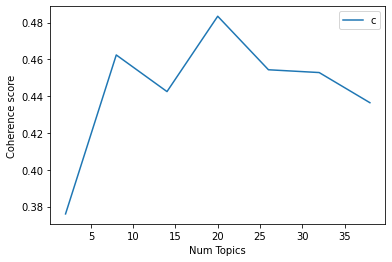

In [17]:
# processed_data = [sent.strip().split(",") for sent in tqdm(open('./data/tokenized_data.csv', 'r', encoding='utf-8').readlines())] 
    
# 정수 인코딩과 빈도수 생성 
dictionary = corpora.Dictionary(book_train_nouns) 
# 출현빈도가 적거나 자주 등장하는 단어는 제거 
dictionary.filter_extremes(no_below=10, no_above=0.05) 
corpus = [dictionary.doc2bow(text) for text in book_train_nouns]
print('Number of unique tokens: %d' % len(dictionary)) 
print('Number of documents: %d' % len(corpus)) 
     
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) 
     
# 최적의 토픽 수 찾기 
find_optimal_number_of_topics(dictionary, corpus, book_train_nouns)


----